In [8]:
from transformers import CLIPModel, SwinModel, AutoImageProcessor, AutoModelForImageClassification
from torch.utils.data import DataLoader
from utils import ImageDatasetTrain
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import json
import torch
import torch.nn as nn

In [9]:
SWIN_CPKT = "microsoft/swin-large-patch4-window12-384-in22k"
SWIN_CPKT2 = "faridkarimli/SWIN_finetuned_kaggle22"

SWIN_22K = "microsoft/swinv2-base-patch4-window12-192-22k"
CLIP_CPKT = "openai/clip-vit-base-patch16"

clip_model = CLIPModel.from_pretrained(CLIP_CPKT, cache_dir="/tmp/clip")
swin_model = AutoModelForImageClassification.from_pretrained(SWIN_CPKT, cache_dir="/tmp/swin", )

# swin_model.load_state_dict(torch.load("/projectnb/herbdl/workspaces/faridkar/herbdl/finetuning/output/SWIN/checkpoint-70-epochs/pytorch_model.bin"))

config.json:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/919M [00:00<?, ?B/s]

In [10]:
swin_model.config

SwinConfig {
  "_name_or_path": "microsoft/swin-large-patch4-window12-384-in22k",
  "architectures": [
    "SwinForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    18,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 192,
  "encoder_stride": 32,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1536,
  "id2label": {
    "0": "organism, being",
    "1": "benthos",
    "2": "heterotroph",
    "3": "cell",
    "4": "person, individual, someone, somebody, mortal, soul",
    "5": "animal, animate_being, beast, brute, creature, fauna",
    "6": "plant, flora, plant_life",
    "7": "food, nutrient",
    "8": "artifact, artefact",
    "9": "hop",
    "10": "check-in",
    "11": "dressage",
    "12": "curvet, vaulting",
    "13": "piaffe",
    "14": "funambulism, tightrope_walking",
    "15": "rock_climbing",
    "16": "contact_sport",
    "17": "outdoor_sport, field_sport",
    "18": "gymnastics, gymnastic_exercise",
    "1

In [11]:
# Add a projection layer if needed to match CLIP's embedding size
class SWIN_CLIP(nn.Module):
    def __init__(self, swin_model, clip_model):
        super(SWIN_CLIP, self).__init__()
        self.swin_model = swin_model
        self.clip_model = clip_model

        for name, param in self.swin_model.named_parameters():
            if 'classifier' not in name and "swinv2.layernorm" not in name and not name.startswith("swinv2.encoder.layers.3"):
                    param.requires_grad = False
            # layer.requires_grad = False
        
        # Add a linear layer to project SWIN embeddings to CLIP's dimension (e.g., 512)
        self.projection1 = nn.Linear(swin_model.config.hidden_size, clip_model.config.projection_dim)
        self.projection2 = nn.Linear(clip_model.config.projection_dim, clip_model.config.projection_dim)
        

    def forward(self, pixel_values, input_ids):
        # Forward pass through SWIN backbone
        try:
            swin_output = self.swin_model(pixel_values)
            vision_outputs = swin_output.last_hidden_state
        except AttributeError:
            swin_output = self.swin_model(pixel_values, output_hidden_states=True)
            vision_outputs = swin_output.hidden_states[-1]
        
        vision_features = self.projection1(vision_outputs[:, 0, :])  # CLS token
        vision_features = F.relu(vision_features)

        vision_features = self.projection2(vision_features)
        vision_features = F.relu(vision_features)
        
        # Forward pass through CLIP's text encoder
        text_outputs = self.clip_model.get_text_features(input_ids)

        # Normalize the vision and text features to compute cosine similarity
        vision_features = vision_features / vision_features.norm(dim=-1, keepdim=True)
        text_outputs = text_outputs / text_outputs.norm(dim=-1, keepdim=True)

        # Compute similarity (cosine similarity is just the dot product after normalization)
        similarity = torch.matmul(vision_features, text_outputs.T)

        # logit_scale is typically initialized as a learnable parameter
        logit_scale = self.clip_model.logit_scale.exp()  # logit_scale starts around 2.6592 in CLIP

        # Multiply similarity scores by logit scale
        logits = logit_scale * similarity

        return logits


In [12]:
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16", cache_dir="/tmp/clip")
image_processor = AutoImageProcessor.from_pretrained("microsoft/swin-base-patch4-window12-384", cache_dir="/tmp/swin")

model = SWIN_CLIP(swin_model, clip_model)
learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of learnable parameters: {learnable_params}")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Number of learnable parameters: 184239954


In [13]:
train_df = pd.read_json("../datasets/train_22_scientific_str.json", lines=True)
val_df = pd.read_json("../datasets/val_22_scientific_str.json", lines=True)

print(f"Train size: {train_df.shape}, Val size: {val_df.shape}. Columns: {train_df.columns}" )

Train size: (671817, 2), Val size: (167955, 2). Columns: Index(['image', 'caption'], dtype='object')


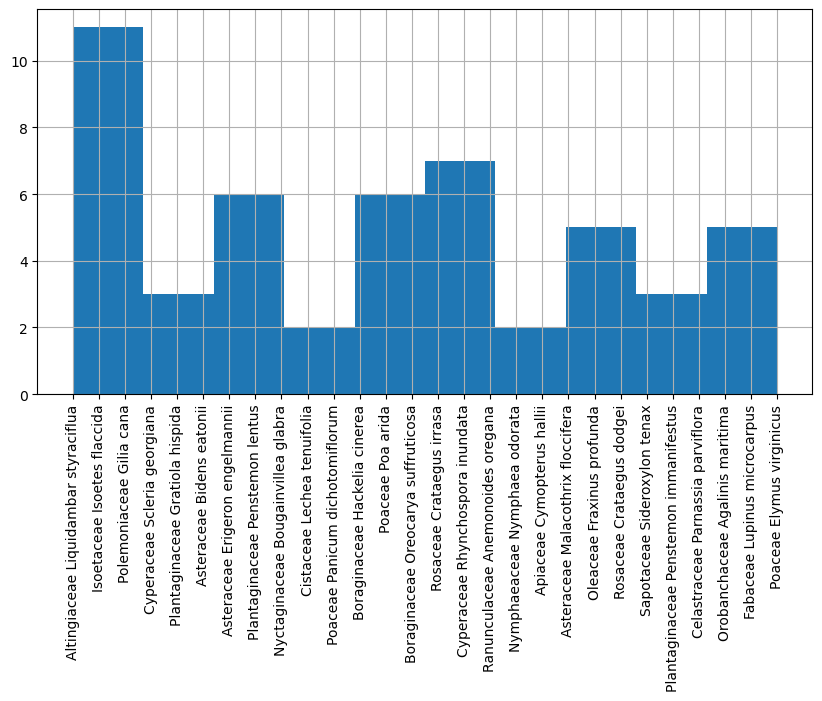

In [14]:
np.random.seed(42)

top_labels = train_df['caption'].value_counts().nlargest(50).index.tolist()
train_df_sample = train_df[train_df['caption'].isin(top_labels)]
val_df_sample = val_df[val_df['caption'].isin(top_labels)]

plt.figure(figsize=(10, 5))
train_df['caption'].iloc[:50].hist(xrot=90)
plt.show()

In [15]:
image_paths = train_df_sample["image"].tolist()
labels = train_df_sample["caption"].tolist()
print(f"Training set size: {train_df_sample.shape}")
print(f"Validation set size: {val_df_sample.shape}")

image_processor = AutoImageProcessor.from_pretrained("microsoft/swin-base-patch4-window12-384", cache_dir="./tmp/swin")

train_dataset = ImageDatasetTrain(image_paths, labels, image_processor)
val_dataset = ImageDatasetTrain(val_df_sample["image"].tolist(), val_df_sample["caption"].tolist(), image_processor)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

/usr3/graduate/faridkar/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Training set size: (3489, 2)
Validation set size: (418, 2)


In [16]:
def contrastive_loss(logits, labels):
    # Symmetric cross-entropy loss for image-to-text and text-to-image
    labels = torch.arange(logits.shape[0], device=logits.device)
    loss_img_to_text = F.cross_entropy(logits, labels)
    loss_text_to_img = F.cross_entropy(logits.T, labels)
    return (loss_img_to_text + loss_text_to_img) / 2

val_labels = set()
for batch in val_dataloader:
    labels = batch['label']
    val_labels.update(labels)
val_labels = list(val_labels)
val_labels_processed = processor(text=val_labels, return_tensors="pt", padding=True).input_ids.to("cuda")
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

def validate(model, val_dataloader, device, verbose=False):
    model.eval()
    correct = 0
    top5 = 0
    top10 = 0

    for batch in val_dataloader:
        correct_label = batch['label'][0]
        pixel_values = batch['pixel_values'].to(device)

        with torch.no_grad():
            logits = model(pixel_values, val_labels_processed)

        predicted_label_idx = logits.argmax().item()

        predicted_label = val_labels[predicted_label_idx]
        correct_label_idx = val_labels.index(correct_label)

        if predicted_label == correct_label:
            if verbose:
                print(f"Correct: {correct_label}, Predicted: {predicted_label}. Number of correct predictions: {correct}/{len(val_dataset)}")
            correct += 1
        
        elif correct_label_idx in logits.topk(5).indices:
            top5 += 1

        elif correct_label_idx in logits.topk(10).indices:
            top10 += 1
        

    return correct, top5, top10

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

EPOCHS = 50

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.5, total_iters=EPOCHS)

losses = []
eval_accs = []

for epoch in tqdm(range(EPOCHS), desc="Epoch"):
    total_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        
        labels = batch['label']
        pixel_values = batch['pixel_values'].to(device)
        input_ids = processor(text=labels, return_tensors="pt", padding=True).input_ids.to(device)

        output = model(pixel_values, input_ids)

        loss = contrastive_loss(output, labels)
        loss.backward()    

        total_loss += loss.item()

        optimizer.step()

    avg_loss = total_loss / 64
    losses += [avg_loss]
    total_loss = 0
    lr_scheduler.step()

    if epoch % 10 == 0 and epoch > 0:
        correct, top5, top10 = validate(model, val_dataloader, device)

        print("--------------------")
        print(f"Epoch: {epoch}")
        print(f"Top 1 accuracy: {correct / len(val_dataset) * 100:.2f}%")
        print("--------------------")

        eval_accs += [correct / len(val_dataset) * 100]
            
# save model

model_name = f"{SWIN_CPKT2.split('/')[1]}_{len(val_labels)}_labels_{EPOCHS}_epochs_v2"
path = f"./checkpoints/{model_name}"
os.makedirs(f"./checkpoints/{model_name}", exist_ok=True)

results = {
    "losses": losses,
    "eval_accs": eval_accs,
    "final_eval_acc": eval_accs[-1],
    "num_labels": len(val_labels),
    "num_learnable_params": learnable_params
}
with open(f"./checkpoints/{model_name}/results.json", "w") as f:
    json.dump(results, f)

torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': losses[-1],
            }, f"./checkpoints/{model_name}/model.pth")

plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(eval_accs, marker="o")
plt.show()

Epoch:  12%|█▏        | 6/50 [57:25<7:02:19, 575.90s/it]

In [ ]:
train_labels = set()


for batch in train_dataloader:
    labels = batch['label']
    train_labels.update(labels)

train_labels = list(train_labels)
print(f"Length of train labels: {len(train_labels)}")
    

Length of train labels: 50


In [ ]:
val_labels = set()
device="cuda"
for batch in val_dataloader:
    labels = batch['label']
    val_labels.update(labels)

all_labels = list(val_labels)
    
all_labels_processed = processor(text=all_labels, return_tensors="pt", padding=True).input_ids.to(device)
all_labels_processed.shape

torch.Size([50, 14])

## Zero-shot classification

In [23]:
train_df['caption'].nunique()

50

In [20]:
train_df[~train_df['caption'].isin(top_labels)]

,image,caption


In [18]:
train_df[~train_df['caption'].isin(top_labels)]['caption'].unique()

array([], dtype=object)

In [17]:
np.random.seed(42)
zeroshot_sample = np.random.choice(train_df[~train_df['caption'].isin(top_labels)]['caption'].unique(), 100)

zeroshot_sample = train_df[train_df['caption'].isin(zeroshot_sample)]
zeroshot_sample.head()


ValueError: 'a' cannot be empty unless no samples are taken

In [ ]:
all_zeroshot_labels = list(zeroshot_sample['caption'].unique())
all_zeroshot_labels_processed = processor(text=all_zeroshot_labels, return_tensors="pt", padding=True).input_ids.to(device)

zeroshot_dataset = ImageDatasetTrain(zeroshot_sample["image"].tolist(), zeroshot_sample["caption"].tolist(), image_processor)
print(f"Length of zeroshot dataset: {len(zeroshot_dataset)}")
zeroshot_dataloader = DataLoader(zeroshot_dataset, batch_size=1, shuffle=False)

model.to(device)
model.eval()

correct = 0
top5 = 0

for batch in tqdm(zeroshot_dataloader, desc="Zero-shot validation"):
    correct_label = batch['label'][0]
    pixel_values = batch['pixel_values'].to(device)

    with torch.no_grad():
        logits = model(pixel_values, all_zeroshot_labels_processed)

    predicted_label_idx = logits.argmax().item()

    predicted_label = all_zeroshot_labels[predicted_label_idx]
    correct_label_idx = all_zeroshot_labels.index(correct_label)
    #print(f"Predicted label: {predicted_label}. Correct label: {correct_label}")

    if predicted_label == correct_label:
        correct += 1
        top5 += 1
    elif correct_label_idx in logits.topk(5).indices:
        # print(f"Predicted label: {predicted_label}. Correct label: {correct_label}")
        # print(f"Top 5 labels: {[all_zeroshot_labels[x] for x in logits.topk(5).indices[0]]}")
        top5 += 1

print(f"Zero-shot top 1 accuracy: {correct / len(zeroshot_dataset) * 100:.2f}%")
print(f"Zero-shot top 5 accuracy: {top5 / len(zeroshot_dataset) * 100:.2f}%")


Length of zeroshot dataset: 4424


Zero-shot validation: 100%|██████████| 4424/4424 [07:38<00:00,  9.64it/s]

Zero-shot top 1 accuracy: 8.34%
Zero-shot top 5 accuracy: 23.17%
